### IMPORT LIBS

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy import percentile
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#Model
from sklearn.ensemble import GradientBoostingRegressor
#Train test split
from sklearn.model_selection import train_test_split
#Mean Absolute Error
from sklearn.metrics import mean_absolute_error
#Imputer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
#Column transformer
from sklearn.compose import ColumnTransformer
#Pipeline
from sklearn.pipeline import Pipeline
#OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#Scaler for numerical variables
from sklearn.preprocessing import RobustScaler
#Cross validation
from sklearn.model_selection import cross_val_score
#GridSearch
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

### Get the data

In [2]:
# Read the data
train_data = pd.read_csv("./train.csv", index_col='Id')
valid_data = pd.read_csv("./test.csv", index_col='Id')

#Remove rows with missing target
train_data.dropna(axis=0, subset= ["SalePrice"], inplace=True)

### Look at the data

In [3]:
#Have a look at the data
train_data.head(n = 10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900


<b>The dataset is composed of 80 variables.
The first step would be to explore these variables to gain some insights. Let's group them based on their type: categorical or numerical.
<br>
Here, we declare the "object" variables as categorical, and the non-"object" as numerical. <br>"MSSubClass" is an exception to this rule (see data description in the Kaggle website), so we reasign it as a categorical variable
</b>

In [4]:
#Numerical cols
numerical_cols = train_data.select_dtypes(exclude = ["object"]).copy()
numerical_cols = numerical_cols.drop(["MSSubClass"], axis = 1)
numerical_cols = list(numerical_cols.columns)
#Categorical
categorical_cols  = train_data.select_dtypes(include = ["object"]).copy()
categorical_cols["MSSubClass"] = train_data["MSSubClass"]
categorical_cols = list(categorical_cols.columns)
#All columns used
my_cols = numerical_cols + categorical_cols

<b>
Let's plot our numerical variables with a simple distribution plot.
<br>
Note: this code may display a warning if you load it into your local jupyter notebook.<br>
</b>
D:\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)<br>
<b>This warning will not appear if you are using a Kaggle notebook.</b>

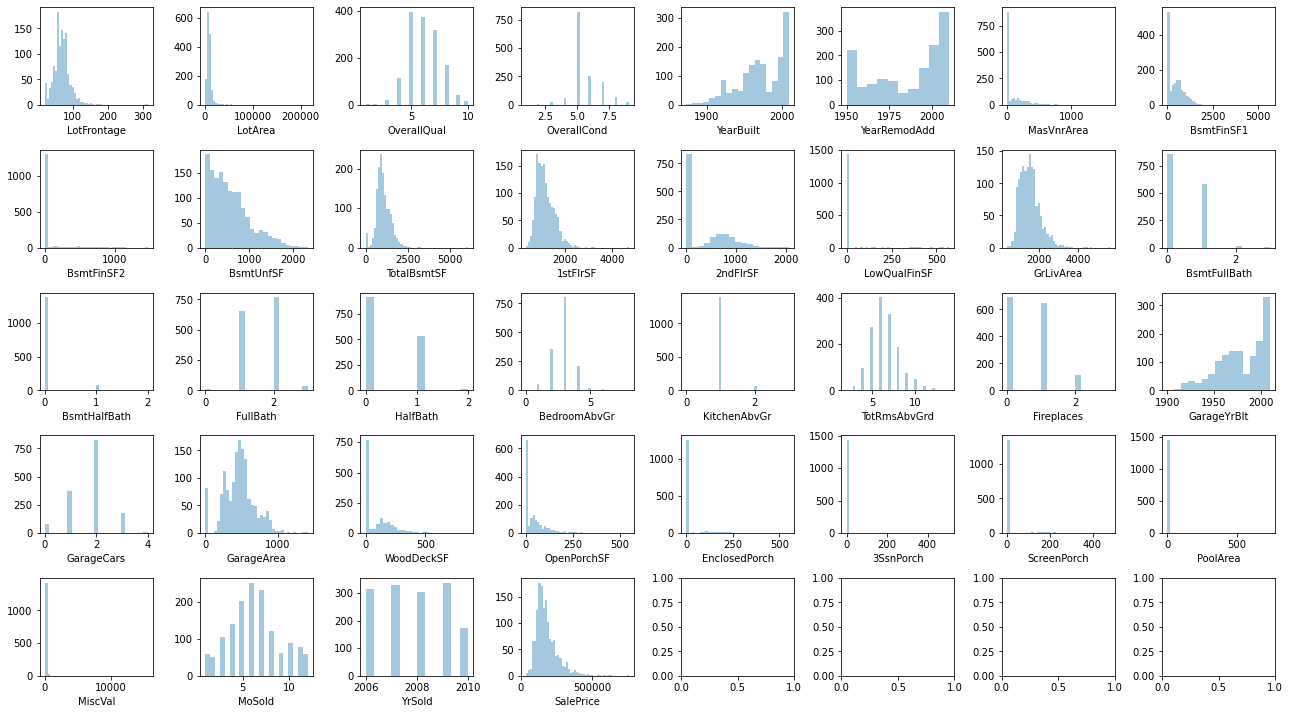

In [5]:
fig, axes = plt.subplots(5, 8, figsize = (18, 10))
axes = axes.flatten()

for i, column in enumerate(train_data[numerical_cols]):
    sns.distplot(train_data[column].dropna(), kde = False, ax = axes[i])
fig.tight_layout(pad = 1.0)

<b>
Some variables have mostly one value (3SsnPorch, ScreenPorch ...), so they likely won't bring any useful information into our model.
<br>We won't use these variables for our predictions.</b>


<b>
Next, let's plot the variables strongly correlated with the target variable
</b>

<AxesSubplot:>

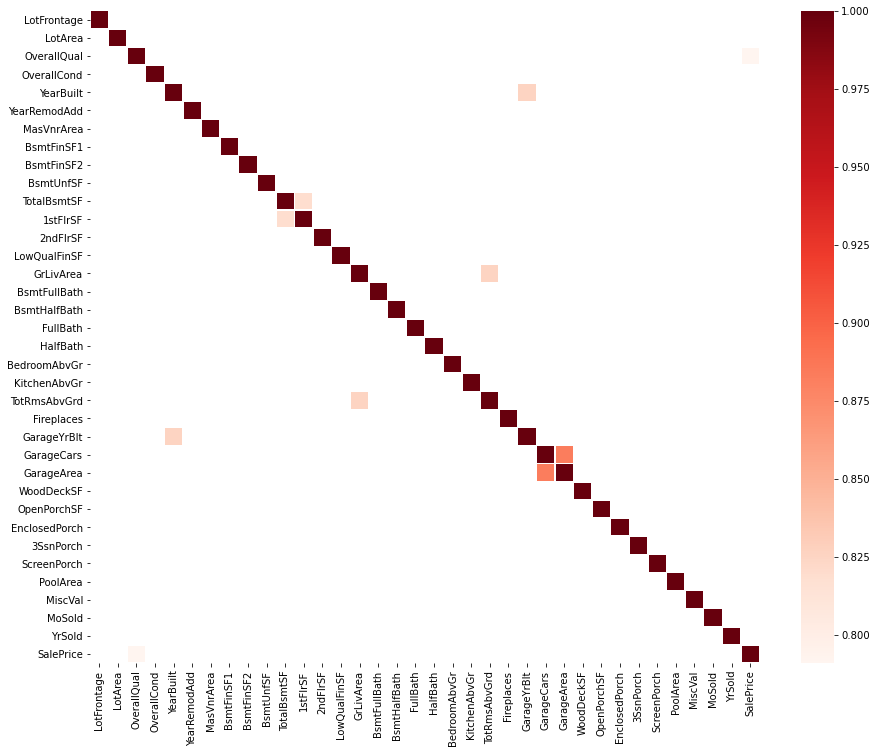

In [6]:
plt.figure(figsize = (15,12))

sns.heatmap(train_data[numerical_cols].corr(), mask = (train_data[numerical_cols].corr() <0.75) 
            ,linewidth = 0.5
            ,cmap = "Reds")

<b>OverallQual and SalePrice are highly correlated, this variable will likely help us a lot in our model
<br> 
<br>Some of these variables retain the same information:</b>
<br>GarageYrBlt is correlated with YearBuilt
<br>TotRmsAbvGrd is correlated with GrLivArea
<br>1stFlrSF is correlated with TotalBsmtSF
<br>And GarageArea is correlated with GarageCars
<br>
    <b>
We should drop some of them. The following graph display all the variables and their linear correlation with the target variable. We can use this graph to know which variables to keep and drop based on which of the two is the most correlated with the target:
<b/>

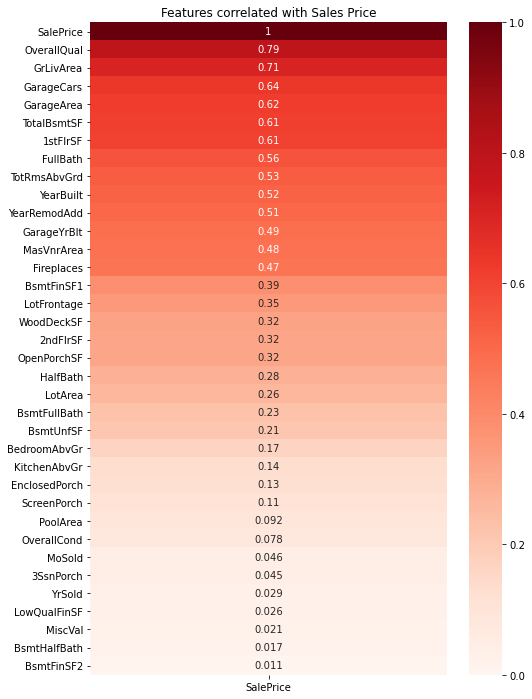

In [7]:
plt.figure(figsize = (8, 12))
heatmap = sns.heatmap(abs(train_data[numerical_cols].corr()[["SalePrice"]]).sort_values(by = "SalePrice", ascending = False), 
                      vmin = 0, 
                      vmax = 1, 
                      annot = True, 
                      cmap = "Reds")
heatmap.set_title("Features correlated with Sales Price");

<b>
The next cell is a legacy code that I used at the beginning of my analysis, I left it here so I can reuse it for my next analysis.<br> My reasoning was the following: <br>
We want to drop variables the least correlated with the target as they aren't supposed to add a lot of information into the model. You can filter the variables by replacing 0.00 in line 2 by the value you see fit (in my case, it was 0.25). However, I later noticed that adding ALL of these variables into my model allowed for a greater score and a jump in the leaderboard. <br>
In real life, you might want to think a bit before including all of your variables in your model: you might overfit your model to your train data, and it won't generalise as well when the model is fed with production data.    
</b>

In [8]:
corr_saleprice = abs(train_data[numerical_cols].corr()[["SalePrice"]]).sort_values(by = "SalePrice", ascending = False)
corr_saleprice = corr_saleprice[corr_saleprice < 0.00].dropna()
list_var_lt25  = list(corr_saleprice.index)

In [9]:
#drop GarageYrBlt keep YearBuilt
#drop TotRmsAbvGrd keep GrLivArea
#drop 1stFlrSF keep  TotalBsmtSF
#drop GarageArea keep GarageCars
train_data.drop(["GarageYrBlt","TotRmsAbvGrd","1stFlrSF", "GarageArea"], axis = 1, inplace = True)
valid_data.drop(["GarageYrBlt","TotRmsAbvGrd","1stFlrSF", "GarageArea"], axis = 1, inplace = True)

#We also drop the features with an abs correlation of less than 0.25
train_data.drop(list_var_lt25, 
                axis = 1, inplace = True)
valid_data.drop(list_var_lt25,
                axis = 1, inplace = True)



In [10]:
#Let's update the cols
#Numerical cols
numerical_cols = train_data.select_dtypes(exclude = ["object"]).copy()
numerical_cols = numerical_cols.drop(["MSSubClass"], axis = 1)
numerical_cols = list(numerical_cols.columns)
#Categorical
categorical_cols  = train_data.select_dtypes(include = ["object"]).copy()
categorical_cols["MSSubClass"] = train_data["MSSubClass"]
categorical_cols = list(categorical_cols.columns)
my_cols = numerical_cols + categorical_cols

<b>
Let's plot the relationship between the target and the numerical variables. It will help us spot linear relationships.
</b>

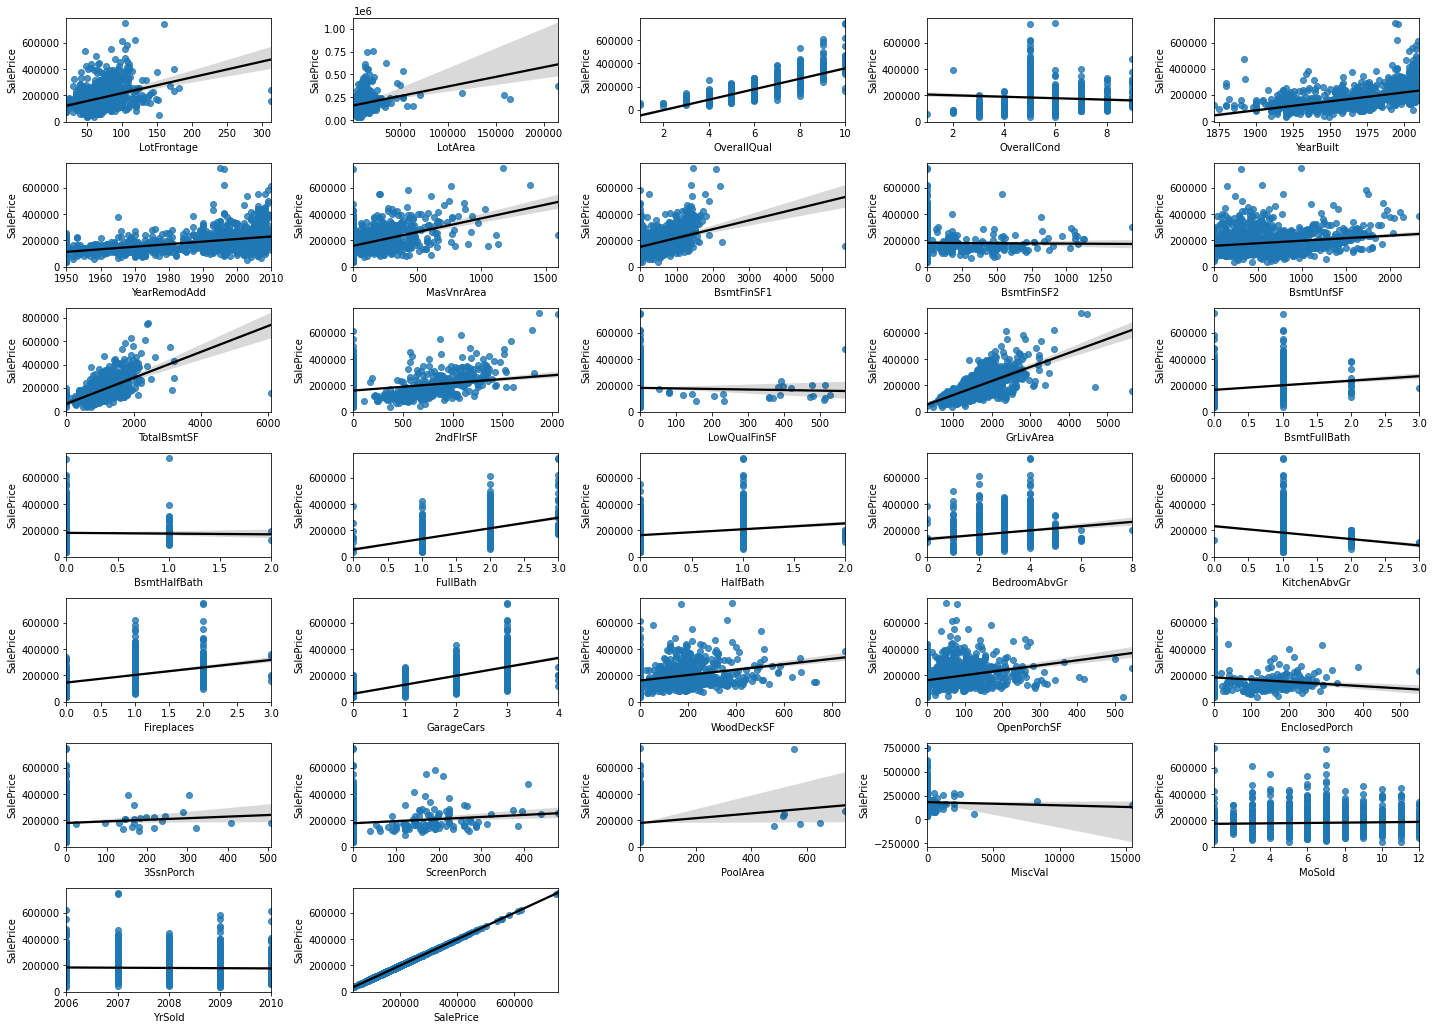

In [11]:
fig = plt.figure(figsize = (20,20))
for index in range(len(train_data[numerical_cols].columns)):
    plt.subplot(10,5,index+1)
    sns.regplot(x = train_data[numerical_cols].iloc[:,index],
                y = train_data[numerical_cols]["SalePrice"],
                data =  train_data[numerical_cols].dropna(),
                line_kws={'color':'black'})
fig.tight_layout(pad = 1.0)

<b> We can spot some discret variables that could be used as categorical variables as well, such as MoSold (Month Sold) or GarageCars.<br>
<br>Speaking of categorical variables, let's check the distribution of our categorical variables:<br>
Same as above, this code may display a warning if you load it into your local jupyter notebook:
</b><br>
D:\anaconda3\envs\ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(

D:\anaconda3\envs\ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\anaconda3\envs\ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\anaconda3\envs\ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\anaconda3\envs\ml\lib\site-packages\seab

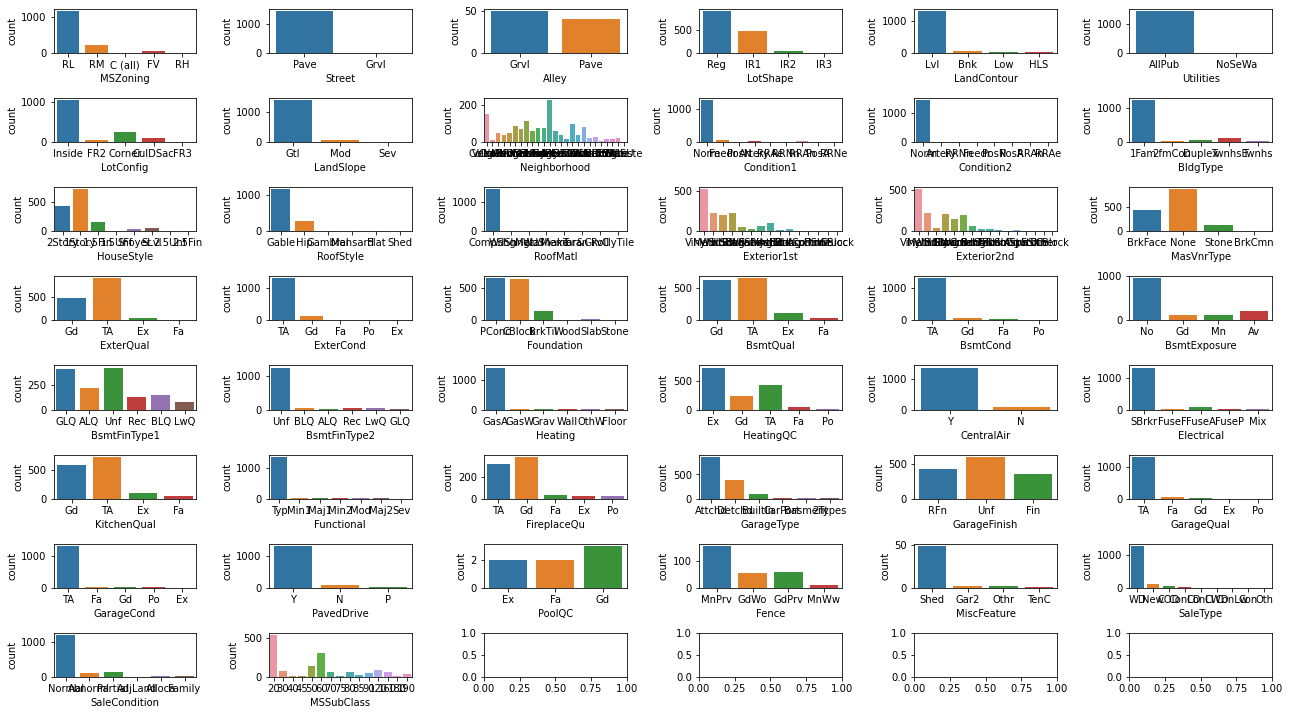

In [12]:
#We have 44 variables, so let's plot a 6*8 grid
fig, axes = plt.subplots(8, 6, figsize = (18, 10))
axes = axes.flatten()

for i, column in enumerate(train_data[categorical_cols].columns):
    sns.countplot(train_data[categorical_cols][column].dropna(), ax =axes[i])
fig.tight_layout(pad = 1.0)

<b>Some variables seem to have only one value, such as RoofMatl. We need to drop them of the dataset later as they won't bring any value to our model </b>

### Deal with missing values
<b>
So far we have used the dropna() function to get rid of the missing values when exploring the data, so now we need to decide what to do with them.
Let's see how many of them we have to deal with:
</b>

In [13]:
# Number of missing values in each column of training data
missing_numerical = (train_data[numerical_cols].isnull().sum())
print(missing_numerical[missing_numerical > 0])

LotFrontage    259
MasVnrArea       8
dtype: int64


In [14]:
missing_categorical = (train_data[categorical_cols].isnull().sum())
print(missing_categorical[missing_categorical > 0])

Alley           1369
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


<b>
Out of 1460 lines, too many data are missing from Alley, PoolQC, and Miscfeature (more than 93% of the data), so let's drop them
    </b>

In [15]:
train_data.drop(["PoolQC","MiscFeature","Alley"], axis = 1, inplace = True)
valid_data.drop(["PoolQC","MiscFeature","Alley"], axis = 1, inplace = True)

In [16]:
#Let's update the cols
#Numerical cols
numerical_cols = train_data.select_dtypes(exclude = ["object"]).copy()
numerical_cols = numerical_cols.drop(["MSSubClass"], axis = 1)
numerical_cols = list(numerical_cols.columns)
#Categorical
categorical_cols  = train_data.select_dtypes(include = ["object"]).copy()
categorical_cols["MSSubClass"] = train_data["MSSubClass"]
categorical_cols = list(categorical_cols.columns)
my_cols = numerical_cols + categorical_cols

### Deal with unique values
<b>Some variables seem to have mostly one value, which is a problem.
Out of 1460 rows, if a variables has 1450 value1 and 10 values2, then it's pointless to add it into the model.
Let's say that if a variable has a value occuring more than 95% of the time, then we potentially have 75 occurences or less of the other values, consequently we don't want this variable in our model

In [17]:
variables_to_drop = []
#for each variable
for col in train_data.columns:
    #count occurences of each value
    counts = train_data[col].value_counts()
    if ( counts.iloc[0] / len(train_data[col]) * 100 ) > 95:
        variables_to_drop.append(col)
variables_to_drop = list(variables_to_drop)

train_data = train_data.drop(variables_to_drop, axis=1)
valid_data = valid_data.drop(variables_to_drop, axis=1)

In [18]:
#Let's update the cols
#Numerical cols
numerical_cols = train_data.select_dtypes(exclude = ["object"]).copy()
numerical_cols = numerical_cols.drop(["MSSubClass"], axis = 1)
numerical_cols = list(numerical_cols.columns)
#Categorical
categorical_cols  = train_data.select_dtypes(include = ["object"]).copy()
categorical_cols["MSSubClass"] = train_data["MSSubClass"]
categorical_cols = list(categorical_cols.columns)
my_cols = numerical_cols + categorical_cols

### Deal with outliers
<b>Outliers are usually not desired in statistics, in this specific case at least.
If we were to look for anormal financial transactions, for example, we would keep these values. In our case, we are going to perform a regression, so we want to get rid of them.<br>
Let's plot some boxplots to find our outliers:

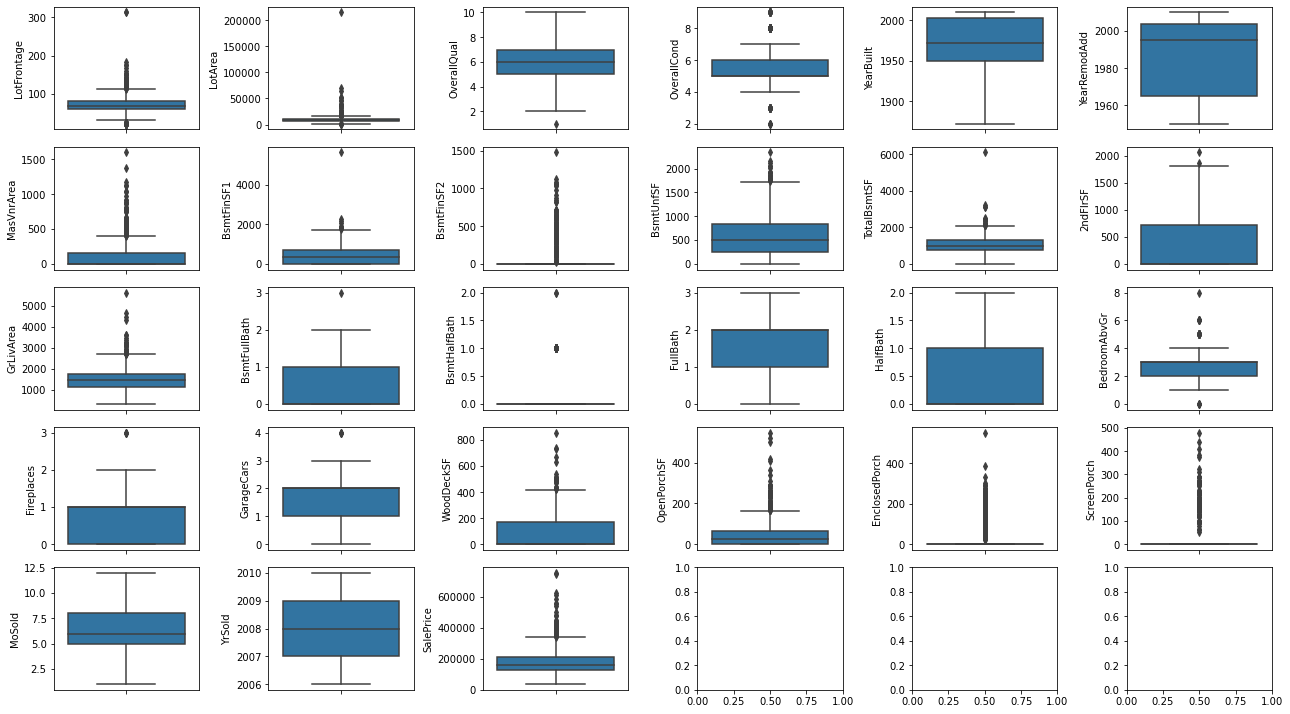

In [19]:
fig, axes = plt.subplots(5, 6, figsize = (18, 10))
axes = axes.flatten()

for i, column in enumerate(train_data[numerical_cols].columns):
    sns.boxplot(y = column, data = train_data[numerical_cols].dropna(), ax = axes[i])
fig.tight_layout(pad = 1.0)

<b>We definitely have some outliers
<br>A nice method to get rid of them would be to compute the mean, the standard deviation, and consider that values out of the range:
<br>mean +/- 2.96 * std as outliers
<br>Unfortunately, the distribution of our numerical variables is not looking normal, so let's use a non-parametric method
<br>We will use the medial and the quartiles of each variables
<br>https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

In [20]:
remove_outliers = ["LotFrontage", "LotArea", "BsmtFinSF1", "TotalBsmtSF", "GrLivArea"]

for col in remove_outliers:
    #find quartiles
    q25, q75 = percentile(train_data[col], 25), percentile(train_data[col], 75)
    iqr = q75 - q25
    cut_off = iqr * 2
    lower, upper = q25 - cut_off, q75 + cut_off
    train_data = train_data.drop(train_data[train_data[col] > upper].index)
    train_data = train_data.drop(train_data[train_data[col] < lower].index)

In [21]:
#Let's update the cols
#Numerical cols
numerical_cols = train_data.select_dtypes(exclude = ["object"]).copy()
numerical_cols = numerical_cols.drop(["MSSubClass", "SalePrice"], axis = 1) #Remove target from features
numerical_cols = list(numerical_cols.columns)
#Categorical
categorical_cols  = train_data.select_dtypes(include = ["object"]).copy()
categorical_cols["MSSubClass"] = train_data["MSSubClass"]
categorical_cols = list(categorical_cols.columns)
my_cols = numerical_cols + categorical_cols

### Obtain target and predictors

In [21]:
y = train_data.SalePrice
X = train_data[my_cols].copy()
#X['MSSubClass'].apply(str)

X_valid = valid_data[my_cols].copy()
#X_valid['MSSubClass'].apply(str)

### Preprocess the data
<b>
Before feeding the data into a model, we need to take care of some steps: 
<br><br>For the numerical variables, we will imput the missing values with the median of each variables, and then scale the data by removing the median and scaling the data according to the quartile range. This way, we are sure that we won't be impacted by large values or outliers.
<br> https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
<br><br>For the categorical variables, we will imput the missing values with the most frequent values of each variables, and one hot encode each variable so it can be processed by the model.
<br> https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
<br><br>
Note: I am heavily relying on sklearn pipelines in my code. A pipeline in our case is simply a serie of steps (imputer, encoder, scaler, model ...) encapsuled together into one pipeline object. 
<br>Instead of calling the fit and transform method of each of these steps separately, we just need one call to perform all of our steps.
<br>It makes the code more readable and easier to modify. Also, it prevents data leakage since the pipeline object deals with fitting and transforming the data

In [22]:
numerical_transformer = Pipeline(steps=[
                                        ('num_imputer', SimpleImputer(strategy="median")),
                                        ('scaler', RobustScaler()),
                                       ])


categorical_transformer = Pipeline(steps=[
                                          ('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                         ])

#Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(transformers=[
                                               ('num', numerical_transformer, numerical_cols),
                                               ('cat', categorical_transformer, categorical_cols)
                                              ])

### Choose a model
<b>
Let's keep things simple with a nice Gradient Booksting Regressor
<b>

In [23]:
model = GradientBoostingRegressor(n_estimators = 500,
                                  random_state = 0,
                                  subsample = 1.0,
                                  max_depth = 3)

### Build the pipeline

In [24]:
my_pipeline = Pipeline(steps=[
                              ('preprocessor', preprocessor),
                              ('model', model)
                             ])

In [25]:
my_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '2ndFlrSF',
                                                   'GrLivArea', 'BsmtFullBath',
          

In [32]:
# Create parameter grid
#parameters = {"model__n_estimators" : [500, 1000, 2000],
#            "model__max_depth" : [3, 6, 9]}

In [33]:
# Model best estimators
#print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["model__learning_rate"])
#print("Max Depth: ", model_xgboost.best_estimator_.get_params()["model__max_depth"])
#print("Subsample: ", model_xgboost.best_estimator_.get_params()["model__subsample"])
#print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["model__n_estimators"])

Learning Rate:  0.01
Gamma:  0
Max Depth:  3
Subsample:  1
Max Features at Split:  1
Alpha:  0.05
Lamda:  0.001
Minimum Sum of the Instance Weight Hessian to Make a Child:  5
Number of Trees:  2000

### Generate test predictions and submit to competition

In [28]:
predictions = my_pipeline.predict(X_valid)

In [29]:
# Save predictions in format used for competition scoring
output = pd.DataFrame({'Id': X_valid.index,
                       'SalePrice': predictions})
output.to_csv('submission.csv', index=False)

### I enjoyed reading: 
Fine-tuning XGBoost in Python like a boss
<br> https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
<br> Overfitting and Underfitting With Machine Learning Algorithms
<br> https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/
<br> Machine Learning Performance Improvement Cheat Sheet
<br> https://machinelearningmastery.com/machine-learning-performance-improvement-cheat-sheet/

### Failed attempts at improving my score

Treating NA as a categorical value on its own didn't work    
<br> Ways To Handle Categorical Column Missing Data & Its Implementations
<br> https://medium.com/analytics-vidhya/ways-to-handle-categorical-column-missing-data-its-implementations-15dc4a56893
<br> (PRO TIP: to read medium articles without subscribing, use incognito mode)

<br>Using Iterative Imputer (for num values) didn't help
<br>https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

<br>Applying the log funtion to the price to make the distribution more normal
<br> Log Transformation: Purpose and Interpretation
<br> https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9


<br>CatBoost didn't perform better than XGB
<br> Why you should learn CatBoost now
<br> https://towardsdatascience.com/why-you-should-learn-catboost-now-390fb3895f76